# Repare dataset

## txt2csv

In [1]:
import re
import csv

input_file = './dataset/ps_encodedcommand_data.txt'
output_file = './dataset/ps_encodedcommand_data.csv'

with open(input_file, 'rb') as file:
    content = file.read()

content_str = content.decode('latin-1')

pattern = re.compile(
        r'######################### START #########################(.*?)#########################  END  #########################',
    re.DOTALL
)

matches = pattern.findall(content_str)

data_list = []

for match in matches:
    original_code = re.search(r'\[Original Code\]\n\n(.*?)\n\n', match, re.DOTALL).group(1).strip()
    filename = re.search(r'\[Filename\]\n\n(.*?)\n\n', match, re.DOTALL).group(1).strip()
    arguments = re.search(r'\[Arguments\]\n\n(.*?)\n\n', match, re.DOTALL).group(1).strip()
    b64_decoded = re.search(r'\[B64 Decoded\]\n\n(.*?)\n\n', match, re.DOTALL).group(1).strip()
    family_name = re.search(r'\[Family Name\]\n\n(.*?)\n\n', match, re.DOTALL).group(1).strip()

    data = {
        'Original Code': original_code,
        'Filename': filename, 
        'Arguments': arguments,
        'B64 Decoded': b64_decoded,
        'Family Name': family_name
    }
    data_list.append(data)

with open(output_file, 'w', newline='', encoding='utf-8') as csvfile:
    fieldnames = ['Original Code', 'Filename', 'Arguments', 'B64 Decoded', 'Family Name']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for data in data_list:
        writer.writerow(data)

print(f'Data has been written to {output_file}')

Data has been written to ./dataset/ps_encodedcommand_data.csv


## preprocess CSV

In [2]:
import pandas as pd
import re
from dataclasses import replace

input_file = './dataset/ps_encodedcommand_data.csv'
output_file = './dataset/data_processed.csv'

try: 
    df = pd.read_csv(input_file)
except Exception as e:
    print(f'Error: {e}')

# print(df.head())

def extract_executable(input_string):
    pattern = re.compile(r'\\\"(.*?)\\\"|(\S+\.exe)|\bpowershell\b', re.IGNORECASE)
    match = pattern.search(input_string)
    if match:
        if match.group(1):
            result = match.group(1)
        elif match.group(2):
            result = match.group(2)
        else:
            result = match.group(0)
        result = result.replace('"', '')
        return result
    return None

# Áp dụng hàm extract_executable lên cột 'Original Code' và tạo cột mới 'Path Exec'
df['Path Exec'] = df['Original Code'].apply(extract_executable)

# print(df.head())

def combine_attributes(row):
    Path_Exec = str(row['Path Exec'])
    Arguments = re.sub(r"[\[\]',]", '', str(row['Arguments']))
    Payload = str(row['B64 Decoded'])

    combine_value = f'{Path_Exec} {Arguments} {Payload}'
    return combine_value

df['Full Payload'] = df.apply(combine_attributes, axis=1)
print(df['Family Name'].unique())

['Shellcode Inject' 'Downloader DFSP' 'Powerfun Reverse' 'SET'
 'Downloader DFSP 2X' 'Unicorn' 'PowerShell Empire' 'Downloader Proxy'
 'Meterpreter RHTTP' 'Scheduled Task COM' 'Downloader IEXDS' 'Unknown'
 'AMSI Bypass' 'VB Task' 'Veil Stream' 'PowerWorm' 'Remote DLL'
 'Downloader Kraken' 'TXT C2' 'BITSTransfer' 'Downloader DFSP DPL'
 'Powerfun Bind' 'Unicorn Modified' 'PowerSploit GTS' 'DynAmite Launcher'
 'Remove AV' 'DynAmite KL']


## Combine Family name to label

In [3]:
import pandas as pd

input_file = './dataset/data_processed.csv'
output_file = './dataset/data_labeled.csv'

try: 
    df = pd.read_csv(input_file)
except Exception as e:
    print(f'Error: {e}')

def map_family_to_label(family_name):
    if pd.isnull(family_name):
        return 'Unknown'

    family_name = family_name.lower()

    # Bypass
    if 'bypass' in family_name or 'remove av' in family_name:
        return 'Bypass'

    # TaskExecution
    elif 'task' in family_name or 'scheduled' in family_name or 'com' in family_name \
        or 'bits' in family_name or 'vb task' in family_name \
        or 'dynamite' in family_name:
        return 'TaskExecution'

    # Downloader
    elif 'downloader' in family_name or 'transfer' in family_name or 'proxy' in family_name \
        or 'iexds' in family_name or 'dfsp' in family_name:
        return 'Downloader'

    # Injector
    elif 'inject' in family_name or 'trojan' in family_name or 'shellcode' in family_name \
        or 'remote dll' in family_name or 'rhttp' in family_name \
        or ('unicorn' in family_name and 'modified' in family_name):
        return 'Injector'

    # Payload
    elif 'power' in family_name or 'empire' in family_name or 'veil' in family_name \
        or 'txt c2' in family_name or ('unicorn' in family_name and 'modified' not in family_name):
        return 'Payload'

    else:
        return 'Unknown'

# Gán nhãn
df['Label'] = df['Family Name'].apply(map_family_to_label)

# Loại bỏ 'Unknown'
row_before = len(df)
df = df[df['Label'] != 'Unknown']
row_after = len(df)
row_removed = row_before - row_after
print(f'Number of rows removed: {row_removed}')

# Thống kê số lượng nhãn
label_counts = df['Label'].value_counts()
print('Label counts:')
print(label_counts)

# Thống kê tỷ lệ phần trăm
label_percentages = (label_counts / len(df)) * 100
print('Label percentages:')
print(label_percentages)

# Lưu file
columns_to_keep = ['Full Payload', 'Label']
df = df[columns_to_keep]
df.to_csv(output_file, index=False)
print(f'DataFrame has been written to {output_file}')


Number of rows removed: 303
Label counts:
Downloader       1511
Injector         1171
Payload          1045
TaskExecution      39
Bypass             10
Name: Label, dtype: int64
Label percentages:
Downloader       40.015890
Injector         31.011653
Payload          27.674788
TaskExecution     1.032839
Bypass            0.264831
Name: Label, dtype: float64
DataFrame has been written to ./dataset/data_labeled.csv


# extend dataset

In [4]:
import pandas as pd
# import matplotlib.pyplot as plt

# ===== Các nhãn hợp lệ theo PowerDetector =====
VALID_LABELS = {'Bypass', 'Downloader', 'Injector', 'Payload', 'TaskExecution'}

def load_and_standardize_csv(file_path):
    """
    Chuẩn hóa dữ liệu từ file CSV:
    - Đổi tên 'Payload' thành 'Full Payload' nếu cần.
    - Loại bỏ NaN và chuỗi 'nan' ở cột Label.
    - Chuẩn hóa và lọc nhãn hợp lệ.
    """
    df = pd.read_csv(file_path)

    if 'Full Payload' not in df.columns and 'Payload' in df.columns:
        df.rename(columns={'Payload': 'Full Payload'}, inplace=True)

    if 'Full Payload' not in df.columns or 'Label' not in df.columns:
        print(f"⚠️ File {file_path} không hợp lệ (thiếu 'Full Payload' hoặc 'Label'). Bỏ qua.")
        return pd.DataFrame()

    df.dropna(subset=['Label'], inplace=True)
    df['Label'] = df['Label'].astype(str).str.strip()
    df = df[df['Label'].str.lower() != 'nan']

    df = df[df['Label'].isin(VALID_LABELS)]

    return df[['Full Payload', 'Label']]

# ===== Main script =====
base_dataset = './dataset/data_labeled.csv'
new_dataset_files = [
    './dataset_extra/dataset/amsi_fail.csv',
    './dataset_extra/dataset/Malicious-PowerShell-Dataset_bazaar_out.csv',
    './dataset_extra/dataset/Malicious-PowerShell-Dataset_hybrid_analysis_out.csv',
    './dataset_extra/dataset/Malicious-PowerShell-Dataset_triage_out.csv',
    './dataset_extra/dataset/mpsd.csv',
    './dataset_extra/dataset/task_exec_from_atomic.csv',
]
output_dataset = './dataset/data_labeled_extended.csv'

df_base = load_and_standardize_csv(base_dataset)
print("\n📊 Phân phối nhãn trong dataset gốc:")
print(df_base['Label'].value_counts())

for file_path in new_dataset_files:
    df_new = load_and_standardize_csv(file_path)
    if not df_new.empty:
        print(f"\n📊 Phân phối nhãn (file: {file_path}):")
        print(df_new['Label'].value_counts())
        df_base = pd.concat([df_base, df_new], ignore_index=True)

# ✅ Lọc kỹ dữ liệu trước khi lưu
df_base['Label'] = df_base['Label'].astype(str).str.strip()
df_base = df_base[
    df_base['Label'].notna() &
    (df_base['Label'].str.lower() != 'nan') &
    (df_base['Label'].str.strip() != '')
]

# 🚨 Lọc dòng nhãn bị lệch cột: Label NaN nhưng Full Payload là tên nhãn
df_base = df_base[~(
    df_base['Label'].isnull() & df_base['Full Payload'].isin(VALID_LABELS)
)]

# 💾 Ghi ra file
df_base.to_csv(output_dataset, index=False)
print(f"\n💾 Dataset mở rộng đã lưu vào: {output_dataset}")

# 📊 Thống kê và biểu đồ
label_counts = df_base['Label'].value_counts()
print("\n📊 Phân phối nhãn sau khi nối:")
print(label_counts)

# plt.figure(figsize=(8, 5))
# label_counts.plot(kind='bar', color='skyblue', edgecolor='black')
# plt.title('Phân phối nhãn trong dataset mở rộng')
# plt.xlabel('Label')
# plt.ylabel('Số lượng mẫu')
# plt.xticks(rotation=45)
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()

# 🔍 Kiểm tra kỹ sau khi lưu
df_check = pd.read_csv(output_dataset)
print("\n✅ Kiểm tra null sau khi lưu:")
print(df_check.isnull().sum())

print("\n🔍 Các dòng có Label null:")
print(df_check[df_check['Label'].isnull()])

print("\n🔍 Các dòng có Label là 'nan' (string):")
print(df_check[df_check['Label'].astype(str).str.lower() == 'nan'])

print("\n🔍 Các dòng có Label là chuỗi rỗng:")
print(df_check[df_check['Label'].astype(str).str.strip() == ''])



📊 Phân phối nhãn trong dataset gốc:
Downloader       1511
Injector         1171
Payload          1045
TaskExecution      39
Bypass             10
Name: Label, dtype: int64

📊 Phân phối nhãn (file: ./dataset_extra/dataset/amsi_fail.csv):
Bypass    965
Name: Label, dtype: int64

📊 Phân phối nhãn (file: ./dataset_extra/dataset/Malicious-PowerShell-Dataset_bazaar_out.csv):
Payload          401
TaskExecution     72
Injector           4
Bypass             1
Name: Label, dtype: int64

📊 Phân phối nhãn (file: ./dataset_extra/dataset/Malicious-PowerShell-Dataset_hybrid_analysis_out.csv):
Payload          70
TaskExecution    37
Bypass            2
Name: Label, dtype: int64

📊 Phân phối nhãn (file: ./dataset_extra/dataset/Malicious-PowerShell-Dataset_triage_out.csv):
Payload          322
TaskExecution    130
Bypass             2
Injector           1
Name: Label, dtype: int64

📊 Phân phối nhãn (file: ./dataset_extra/dataset/mpsd.csv):
Payload          1003
TaskExecution      18
Injector          

In [5]:
import pandas as pd

df = pd.read_csv('./dataset/data_labeled_extended.csv')

null_columns = df.columns[df.isnull().any()]

if not null_columns.empty:
    print("Các cột chứa giá trị null:")
    print(null_columns)
else:
    print("Không có cột nào chứa giá trị null.")

Không có cột nào chứa giá trị null.


# Full Payload length

## Analyze

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Đường dẫn file CSV đã được lưu trước đó
input_dataset = './dataset/data_labeled_extended.csv'

# Đọc file CSV
df = pd.read_csv(input_dataset)

# Tính độ dài chuỗi Full Payload
df['Payload Length'] = df['Full Payload'].astype(str).apply(len)

# Hiển thị thống kê mô tả
print("\n📏 Thống kê chiều dài 'Full Payload':")
print(df['Payload Length'].describe())

# Vẽ biểu đồ histogram phân phối độ dài
plt.figure(figsize=(10, 5))
plt.hist(df['Payload Length'], bins=50, color='orange', edgecolor='black')
plt.title('Phân phối độ dài Full Payload')
plt.xlabel('Độ dài (số ký tự)')
plt.ylabel('Số lượng mẫu')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# ===== Đề xuất giới hạn độ dài =====
threshold_95 = df['Payload Length'].quantile(0.95)
threshold_99 = df['Payload Length'].quantile(0.99)

print(f"\n🎯 Ngưỡng 95%: {int(threshold_95)} ký tự")
print(f"🎯 Ngưỡng 99%: {int(threshold_99)} ký tự")

# Vẽ biểu đồ tập trung vào phần lớn dữ liệu (dưới 10.000 ký tự)
plt.figure(figsize=(10, 5))
plt.hist(df[df['Payload Length'] < 10000]['Payload Length'], bins=50, color='teal', edgecolor='black')
plt.title('Phân phối độ dài Payload (lọc dưới 10.000 ký tự)')
plt.xlabel('Độ dài (số ký tự)')
plt.ylabel('Số lượng mẫu')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Clean dataset


✂️ Đã loại bỏ 538 dòng có Full Payload dài hơn 10000 ký tự.
✅ Dataset sau khi cắt còn lại: 7682 dòng.

📊 Phân phối nhãn sau khi cắt:
Payload          2427
TaskExecution    1587
Downloader       1511
Injector         1178
Bypass            979
Name: Label, dtype: int64


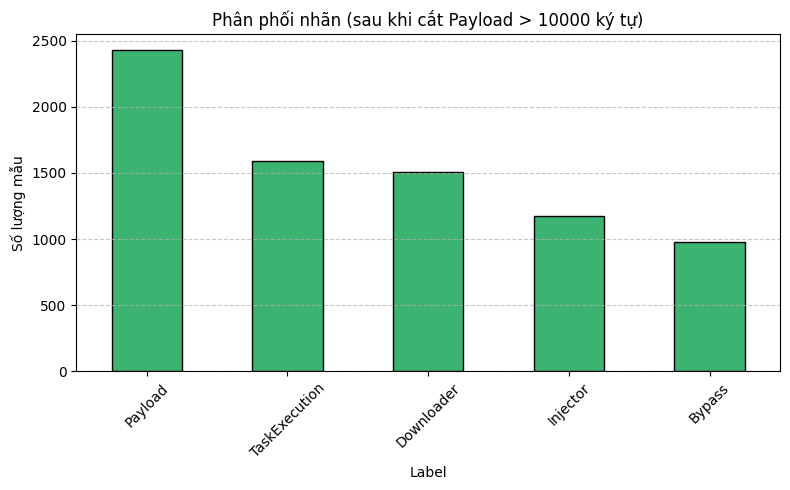


💾 File đã lưu: ./dataset/data_labeled_extended.csv


In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# ===== Tham số =====
input_file = './dataset/data_labeled_extended.csv'
output_file = input_file
max_length = 10000  # Ngưỡng giới hạn độ dài Full Payload

# ===== Đọc dữ liệu =====
df = pd.read_csv(input_file)
df['Payload Length'] = df['Full Payload'].astype(str).apply(len)

# ===== Cắt dữ liệu theo ngưỡng =====
initial_count = len(df)
df_truncated = df[df['Payload Length'] <= max_length].copy()
removed_count = initial_count - len(df_truncated)

# ===== Kết quả =====
print(f"\n✂️ Đã loại bỏ {removed_count} dòng có Full Payload dài hơn {max_length} ký tự.")
print(f"✅ Dataset sau khi cắt còn lại: {len(df_truncated)} dòng.")

# ===== Phân phối nhãn =====
label_counts = df_truncated['Label'].value_counts()
print("\n📊 Phân phối nhãn sau khi cắt:")
print(label_counts)

# ===== Biểu đồ =====
plt.figure(figsize=(8, 5))
label_counts.plot(kind='bar', color='mediumseagreen', edgecolor='black')
plt.title(f'Phân phối nhãn (sau khi cắt Payload > {max_length} ký tự)')
plt.xlabel('Label')
plt.ylabel('Số lượng mẫu')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# ===== Lưu dữ liệu mới =====
df_truncated = df_truncated[['Full Payload', 'Label']]  # Giữ lại 2 cột chính
df_truncated.to_csv(output_file, index=False)
print(f"\n💾 File đã lưu: {output_file}")


## deobfuscate 3 layer

In [ ]:
import base64
import re
import binascii
import zlib
import gzip
from Crypto.Cipher import AES
from Crypto.Util.Padding import unpad

# ===== DEOBFUSCATION LOGIC =====
def remove_comments(script: str) -> str:
    """Xóa chú thích (cả dòng và khối)"""
    script = re.sub(r'#.*', '', script)  # Xóa chú thích một dòng
    script = re.sub(r'<#.*?#>', '', script, flags=re.DOTALL)  # Xóa chú thích khối
    return script

def decode_base64(script: str) -> str:
    """Giải mã Base64"""
    try:
        # Tìm kiếm các chuỗi Base64 và giải mã chúng
        base64_pattern = r'[A-Za-z0-9+/=]{4,}'
        script = re.sub(base64_pattern, lambda m: base64.b64decode(m.group(0)).decode('utf-8', errors='ignore') if m.group(0).strip() else m.group(0), script)
    except Exception as e:
        print(f"Base64 decoding error: {e}")
    return script

def convert_ascii(script: str) -> str:
    """Chuyển đổi [char]X thành ký tự tương ứng"""
    pattern = r'\[char\](\d+)'
    script = re.sub(pattern, lambda m: chr(int(m.group(1))), script)
    return script

def decompress(script: str) -> str:
    """Giải nén chuỗi nén (gzip, zlib)"""
    # Giải nén zlib
    try:
        zlib_pattern = r'(?<=\bcompressed\b\s*=\s*")[A-Za-z0-9+/=]{4,}"'
        script = re.sub(zlib_pattern, lambda m: zlib.decompress(base64.b64decode(m.group(0))).decode('utf-8', errors='ignore'), script)
    except Exception as e:
        print(f"Zlib decompression error: {e}")
    
    # Giải nén gzip
    try:
        gzip_pattern = r'(?<=\bgzip\b\s*=\s*")[A-Za-z0-9+/=]{4,}"'
        script = re.sub(gzip_pattern, lambda m: gzip.decompress(base64.b64decode(m.group(0))).decode('utf-8', errors='ignore'), script)
    except Exception as e:
        print(f"Gzip decompression error: {e}")
    
    return script

def decrypt_hex(script: str) -> str:
    """Giải mã chuỗi hex"""
    hex_pattern = r'([A-Fa-f0-9]{2})+'
    script = re.sub(hex_pattern, lambda m: binascii.unhexlify(m.group(0)).decode('utf-8', errors='ignore'), script)
    return script

def decrypt_aes(script: str, key: bytes) -> str:
    """Giải mã AES (cần một khóa cụ thể để giải mã)"""
    try:
        cipher = AES.new(key, AES.MODE_CBC, iv=b'0123456789abcdef')  # Sử dụng IV mặc định (cần được xác định trong thực tế)
        decrypted = unpad(cipher.decrypt(bytes.fromhex(script)), AES.block_size)
        return decrypted.decode('utf-8', errors='ignore')
    except Exception as e:
        print(f"AES decryption error: {e}")
        return script

def normalize_variable_names(script: str) -> str:
    """Thay thế biến ngẫu nhiên bằng tên chuẩn hóa"""
    script = re.sub(r'\$[a-zA-Z0-9_]+', '$variable', script)  # Thay thế tên biến ngẫu nhiên thành $variable
    return script

def remove_extra_spaces(script: str) -> str:
    """Thay thế nhiều khoảng trắng/tab/xuống dòng bằng một khoảng trắng duy nhất"""
    script = re.sub(r'\s+', ' ', script)
    return script.strip()

def normalize_syntax(script: str) -> str:
    """Chuẩn hóa cú pháp về TitleCase (ví dụ: Get-Process thay vì get-process)"""
    script = re.sub(r'\b(get|set|new|remove|add|invoke)\b', lambda m: m.group(0).capitalize(), script)
    return script

# ===== FULL DEOBFUSCATION =====
def deobfuscate_script(script: str, aes_key: bytes) -> str:
    script = remove_comments(script)  # Xóa chú thích
    script = decode_base64(script)  # Giải mã Base64
    script = convert_ascii(script)  # Chuyển đổi ký tự ASCII
    script = decompress(script)  # Giải nén (gzip, zlib)
    script = decrypt_hex(script)  # Giải mã hex
    script = decrypt_aes(script, aes_key)  # Giải mã AES
    script = normalize_variable_names(script)  # Thay thế biến ngẫu nhiên
    script = remove_extra_spaces(script)  # Chuẩn hóa khoảng trắng
    script = normalize_syntax(script)  # Chuẩn hóa cú pháp
    return script

# ===== APPLY TO CSV =====
input_file = './dataset/data_labeled_extended.csv'

try:
    df = pd.read_csv(input_file)
except Exception as e:
    print(f"❌ Error reading {input_file}: {e}")
    exit()

# Deobfuscate từng dòng và ghi đè vào cột Full Payload
print("🔁 Deobfuscating and overwriting Full Payload...")

# Cần định nghĩa key AES để giải mã
aes_key = b'0123456789abcdef'  # Ví dụ khóa AES (thay thế theo yêu cầu thực tế)

df['Full Payload'] = df['Full Payload'].fillna('').apply(lambda x: deobfuscate_script(x, aes_key))

# Ghi đè lại file cũ
df.to_csv(input_file, index=False)
print(f"✅ Done. Updated file saved to: {input_file}")


🔁 Deobfuscating and overwriting Full Payload...
✅ Done. Updated file saved to: ./dataset/data_labeled_extended.csv
📊 Deobfuscation rate: 0.00%


In [8]:
print(df.columns)


Index(['Full Payload', 'Label'], dtype='object')


# Extract vector

## rela2vec

In [ ]:
# import pandas as pd
# import spacy
# import networkx as nx
# import pickle
# import numpy as np
# import os
# from node2vec import Node2Vec
# from tqdm import tqdm
# from concurrent.futures import ProcessPoolExecutor, as_completed

# # ================== CONFIG ==================
# input_file = './dataset/data_labeled_extended.csv'
# output_file = input_file
# rela2vec_dir = './vectorization/rela2vec'
# graphs_file = os.path.join(rela2vec_dir, 'semantic_graph_extended.pkl')
# os.makedirs(rela2vec_dir, exist_ok=True)

# # ============= LOAD DATA =============
# df = pd.read_csv(input_file)

# if 'Rela2Vec' not in df.columns:
#     df['Rela2Vec'] = ''
# else:
#     df['Rela2Vec'] = df['Rela2Vec'].astype(str)

# # ============= BUILD GRAPHS =============
# def build_graph(idx, payload):
#     try:
#         nlp = spacy.load("en_core_web_sm")
#         nlp.max_length = 20_000_000  # hỗ trợ văn bản dài
#         doc = nlp(payload)
#         G = nx.Graph()

#         for ent in doc.ents:
#             G.add_node(ent.text, type=ent.label_)

#         for sent in doc.sents:
#             ents = [ent.text for ent in sent.ents]
#             for i in range(len(ents)):
#                 for j in range(i + 1, len(ents)):
#                     G.add_edge(ents[i], ents[j])

#         return idx, G
#     except Exception as e:
#         print(f"❌ Error building graph at idx={idx}: {e}")
#         return idx, nx.Graph()

# if os.path.exists(graphs_file):
#     print(f"✅ Found existing semantic graph at {graphs_file}. Loading...")
#     with open(graphs_file, 'rb') as f:
#         graphs = pickle.load(f)
# else:
#     print("⏳ No existing graph found. Building semantic graphs in parallel...")
#     full_payloads = df['Full Payload'].dropna()
#     graphs = {}

#     with ProcessPoolExecutor(max_workers=16) as executor:
#         futures = {executor.submit(build_graph, idx, payload): idx for idx, payload in full_payloads.items()}
#         for future in tqdm(as_completed(futures), total=len(futures), desc="Building Graphs (Parallel)"):
#             idx, G = future.result()
#             graphs[idx] = G

#     with open(graphs_file, 'wb') as f:
#         pickle.dump(graphs, f)
#     print(f"✅ Saved semantic graphs to {graphs_file}")

# # ============= EMBEDDING =============
# def embed_graph(idx, graph_data):
#     try:
#         G = graph_data
#         if G is None or len(G.nodes) == 0:
#             return idx, ' '.join(['0'] * 128)

#         node2vec = Node2Vec(G, dimensions=128, walk_length=30, num_walks=200, workers=4, quiet=True)
#         model = node2vec.fit(window=10, min_count=1, batch_words=4)
#         node_embeddings = model.wv
#         vec = np.mean([node_embeddings[node] for node in G.nodes if node in node_embeddings], axis=0)
#         return idx, ' '.join(map(str, vec))
#     except Exception as e:
#         print(f"⚠️ Node2Vec error at idx={idx}: {e}")
#         return idx, ' '.join(['0'] * 128)

# missing_indices = [
#     i for i in range(len(df))
#     if pd.isna(df.at[i, 'Rela2Vec']) or str(df.at[i, 'Rela2Vec']).strip().lower() in ['nan', '']
# ]

# print(f"🚀 Embedding {len(missing_indices)} graphs using ProcessPoolExecutor...")
# batch_size = 100
# with ProcessPoolExecutor(max_workers=16) as executor:
#     futures = {executor.submit(embed_graph, idx, graphs.get(idx)): idx for idx in missing_indices}
#     completed = 0

#     for future in tqdm(as_completed(futures), total=len(futures), desc="Embedding (ProcessPool)"):
#         idx, vec = future.result()
#         df.at[idx, 'Rela2Vec'] = vec
#         completed += 1

#         if completed % batch_size == 0:
#             df.to_csv(output_file, index=False)
#             print(f"💾 Auto-saved after {completed} records.")

# # ============= SAVE FINAL =============
# df.to_csv(output_file, index=False)
# print(f"✅ Done! Rela2Vec vectors saved to {output_file}")


## Improve rela2vec

In [10]:
import pandas as pd

df = pd.read_csv('./dataset/data_labeled_extended.csv')

# Xoá 2 cột theo tên
df.drop(columns=['Rela2Vec'], inplace=True)

# Ghi lại file mới (hoặc ghi đè nếu bạn muốn)
df.to_csv('./dataset/data_labeled_extended.csv', index=False)



KeyError: "['Rela2Vec'] not found in axis"

### imporve 1 *good*

In [ ]:
import pandas as pd
import spacy
import networkx as nx
import pickle
import numpy as np
import os
from node2vec import Node2Vec
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed

# ================== CONFIG ==================
input_file = './dataset/data_labeled_extended.csv'
output_file = input_file
rela2vec_dir = './vectorization/rela2vec'
graphs_file = os.path.join(rela2vec_dir, 'semantic_graph_extended.pkl')
os.makedirs(rela2vec_dir, exist_ok=True)

# ============= LOAD DATA =============
df = pd.read_csv(input_file)

if 'Rela2Vec' not in df.columns:
    df['Rela2Vec'] = ''
else:
    df['Rela2Vec'] = df['Rela2Vec'].astype(str)

# ============= BUILD GRAPHS =============
def build_graph(idx, payload):
    try:
        # Khởi tạo NLP chỉ 1 lần (đưa ra ngoài nếu nhiều dòng gọi)
        nlp = spacy.load("en_core_web_sm")
        nlp.max_length = 20_000_000
        doc = nlp(payload)
        
        G = nx.DiGraph()  # ✅ Dùng Directed Graph

        # Tạo node từ thực thể
        for ent in doc.ents:
            G.add_node(ent.text, type=ent.label_)

        # Thêm cạnh có nhãn theo loại quan hệ: "co_occurs_with" trong cùng câu
        for sent in doc.sents:
            ents = [ent.text for ent in sent.ents]
            for i in range(len(ents)):
                for j in range(i + 1, len(ents)):
                    # Tạo cạnh có chiều (ent[i] → ent[j]) với nhãn
                    G.add_edge(ents[i], ents[j], relation="co_occurs")

        return idx, G
    except Exception as e:
        print(f"❌ Error building graph at idx={idx}: {e}")
        return idx, nx.DiGraph()


if os.path.exists(graphs_file):
    print(f"✅ Found existing semantic graph at {graphs_file}. Loading...")
    with open(graphs_file, 'rb') as f:
        graphs = pickle.load(f)
else:
    print("⏳ No existing graph found. Building semantic graphs in parallel...")
    full_payloads = df['Full Payload'].dropna()
    graphs = {}

    with ProcessPoolExecutor(max_workers=16) as executor:
        futures = {executor.submit(build_graph, idx, payload): idx for idx, payload in full_payloads.items()}
        for future in tqdm(as_completed(futures), total=len(futures), desc="Building Graphs (Parallel)"):
            idx, G = future.result()
            graphs[idx] = G

    with open(graphs_file, 'wb') as f:
        pickle.dump(graphs, f)
    print(f"✅ Saved semantic graphs to {graphs_file}")

# ============= EMBEDDING =============
def embed_graph(idx, graph_data):
    try:
        G = graph_data
        if G is None or len(G.nodes) == 0:
            return idx, ' '.join(['0'] * 128)

        node2vec = Node2Vec(G, dimensions=128, walk_length=30, num_walks=200, workers=4, quiet=True)
        model = node2vec.fit(window=10, min_count=1, batch_words=4)
        node_embeddings = model.wv
        vec = np.mean([node_embeddings[node] for node in G.nodes if node in node_embeddings], axis=0)
        return idx, ' '.join(map(str, vec))
    except Exception as e:
        print(f"⚠️ Node2Vec error at idx={idx}: {e}")
        return idx, ' '.join(['0'] * 128)

missing_indices = [
    i for i in range(len(df))
    if pd.isna(df.at[i, 'Rela2Vec']) or str(df.at[i, 'Rela2Vec']).strip().lower() in ['nan', '']
]

print(f"🚀 Embedding {len(missing_indices)} graphs using ProcessPoolExecutor...")
batch_size = 100
with ProcessPoolExecutor(max_workers=16) as executor:
    futures = {executor.submit(embed_graph, idx, graphs.get(idx)): idx for idx in missing_indices}
    completed = 0

    for future in tqdm(as_completed(futures), total=len(futures), desc="Embedding (ProcessPool)"):
        idx, vec = future.result()
        df.at[idx, 'Rela2Vec'] = vec
        completed += 1

        if completed % batch_size == 0:
            df.to_csv(output_file, index=False)
            print(f"💾 Auto-saved after {completed} records.")

# ============= SAVE FINAL =============
df.to_csv(output_file, index=False)
print(f"✅ Done! Rela2Vec vectors saved to {output_file}")


### Improve 2

In [11]:
import pandas as pd
import spacy
import networkx as nx
import pickle
import numpy as np
import os
from node2vec import Node2Vec
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed

# ================== CONFIG ==================
input_file = './dataset/data_labeled_extended.csv'
output_file = input_file
rela2vec_dir = './vectorization/rela2vec'
graphs_file = os.path.join(rela2vec_dir, 'semantic_graph_extended.pkl')
os.makedirs(rela2vec_dir, exist_ok=True)

# ============= LOAD DATA =============
df = pd.read_csv(input_file)

if 'Rela2Vec' not in df.columns:
    df['Rela2Vec'] = ''
else:
    df['Rela2Vec'] = df['Rela2Vec'].astype(str)

# ============= BUILD GRAPHS =============
print("⏳ Loading spaCy model...")
nlp = spacy.load("en_core_web_sm")
nlp.max_length = 20_000_000

import re

def extract_custom_entities(payload):
    entities = set()
    # Match IP/URL
    entities.update(re.findall(r'https?://[^\s"\'()]+', payload))
    entities.update(re.findall(r'\b\d{1,3}(?:\.\d{1,3}){3}\b', payload))
    # Match variables
    entities.update(re.findall(r'\$[a-zA-Z_]\w*', payload))
    # Match encoded string fragments
    entities.update(re.findall(r'base64[a-zA-Z0-9+/=]+', payload, flags=re.IGNORECASE))
    return entities


def build_graph(idx, payload):
    try:
        doc = nlp(payload)
        G = nx.DiGraph()
        node_map = {}
        node_id = 0

        # SpaCy entities
        for ent in doc.ents:
            key = ent.text.strip()
            if key not in node_map:
                node_map[key] = node_id
                G.add_node(node_id, type=ent.label_)
                node_id += 1

        # ➕ Thêm custom entities
        for ent in extract_custom_entities(payload):
            if ent not in node_map:
                node_map[ent] = node_id
                G.add_node(node_id, type="Custom")
                node_id += 1

        # Edges: co-occurrence trong câu
        for sent in doc.sents:
            ents = [ent.text.strip() for ent in sent.ents]
            for i in range(len(ents)):
                for j in range(i + 1, len(ents)):
                    if ents[i] in node_map and ents[j] in node_map:
                        G.add_edge(node_map[ents[i]], node_map[ents[j]], relation="co_occurs")

        if G.number_of_nodes() == 0:
            # fallback để tránh lỗi về sau
            G.add_node(0, type="Empty")

        return idx, G
    except Exception as e:
        print(f"❌ Error at idx={idx}: {e}")
        return idx, nx.DiGraph()


if os.path.exists(graphs_file):
    print(f"✅ Found existing semantic graph at {graphs_file}. Loading...")
    with open(graphs_file, 'rb') as f:
        graphs = pickle.load(f)
else:
    print("⏳ No existing graph found. Building semantic graphs in parallel...")
    full_payloads = df['Full Payload'].dropna()
    graphs = {}

    with ProcessPoolExecutor(max_workers=16) as executor:
        futures = {executor.submit(build_graph, idx, payload): idx for idx, payload in full_payloads.items()}
        for future in tqdm(as_completed(futures), total=len(futures), desc="Building Graphs (Parallel)"):
            idx, G = future.result()
            graphs[idx] = G

    with open(graphs_file, 'wb') as f:
        pickle.dump(graphs, f)
    print(f"✅ Saved semantic graphs to {graphs_file}")

# ============= EMBEDDING =============
from karateclub import Graph2Vec

print("🚀 Embedding graphs using Graph2Vec...")

# Luôn xử lý toàn bộ records
idx_list = []
graph_list = []

for idx in df.index:
    G = graphs.get(idx)
    if G and len(G.nodes) > 0:
        idx_list.append(idx)
        graph_list.append(G)
    else:
        # Nếu không có graph hợp lệ → fallback luôn
        df.at[idx, 'Rela2Vec'] = ' '.join(['0'] * 128)


# Huấn luyện Graph2Vec
model = Graph2Vec(dimensions=128, wl_iterations=2)
model.fit(graph_list)
embedding_matrix = model.get_embedding()

# Gán embedding vào DataFrame
for i, idx in enumerate(idx_list):
    try:
        vec = embedding_matrix[i]
        if vec.shape != (128,):
            raise ValueError("Shape mismatch")
        vec_str = ' '.join(map(str, vec))
    except:
        vec_str = ' '.join(['0'] * 128)  # fallback nếu lỗi
    df.at[idx, 'Rela2Vec'] = vec_str


print(f"✅ Đã sinh xong {len(idx_list)} vector Rela2Vec bằng Graph2Vec.")

# ===== Check Rela2Vec vector lỗi =====
print("\n📋 Kiểm tra vector Rela2Vec lỗi sau khi embedding:")
rela2vec_errors = []

for idx in df.index:
    vec = df.at[idx, 'Rela2Vec']
    try:
        vec_arr = np.fromstring(str(vec), sep=' ')
        if vec_arr.shape != (128,):
            rela2vec_errors.append((idx, vec_arr.shape, df.at[idx, 'Label']))
    except Exception as e:
        rela2vec_errors.append((idx, 'parse_error', df.at[idx, 'Label']))

print(f"🔹 Tổng số vector lỗi: {len(rela2vec_errors)}")
for idx, shape, label in rela2vec_errors[:10]:  # chỉ in 10 dòng đầu
    print(f"❌ Row {idx}: shape = {shape}, Label = {label}")


# ============= SAVE FINAL =============
df.to_csv(output_file, index=False)
print(f"✅ Done! Rela2Vec vectors saved to {output_file}")

⏳ Loading spaCy model...
⏳ No existing graph found. Building semantic graphs in parallel...


Building Graphs (Parallel): 100%|██████████| 7673/7673 [00:15<00:00, 506.61it/s] 


✅ Saved semantic graphs to ./vectorization/rela2vec/semantic_graph_extended.pkl
🚀 Embedding graphs using Graph2Vec...
✅ Đã sinh xong 7673 vector Rela2Vec bằng Graph2Vec.

📋 Kiểm tra vector Rela2Vec lỗi sau khi embedding:
🔹 Tổng số vector lỗi: 0
✅ Done! Rela2Vec vectors saved to ./dataset/data_labeled_extended.csv


In [12]:
df = pd.read_csv('./dataset/data_labeled_extended.csv')
print(df.head())

                                        Full Payload       Label  \
0  \C:\\Windows\\System32\\WindowsPowerShell\\v1....    Injector   
1  \C:\\Windows\\System32\\WindowsPowerShell\\v1....  Downloader   
2  \C:\\Windows\\System32\\WindowsPowerShell\\v1....    Injector   
3  powershell.exe -nop -wind hidden -Exec Bypass ...     Payload   
4  powershell -window hidden -enc $1 = '$c = ''[D...    Injector   

                                            Char2Vec  \
0  -0.5455255 0.42318872 -0.17632817 -0.3003589 -...   
1  0.37869638 0.2550347 0.0365349 -0.77686214 -0....   
2  -0.54968446 0.40890148 -0.17841007 -0.35131034...   
3  0.14741817 -0.30198452 -0.216338 -0.3602558 0....   
4  -0.4482412 0.37546468 -0.16848725 -0.38005945 ...   

                                           Token2Vec  \
0  0.4729758 1.4146476 1.5324426 -0.33156413 -1.5...   
1  1.0633844 -0.39044008 1.812115 -1.3040223 -0.7...   
2  0.48852244 1.4663689 1.5531585 -0.28419355 -1....   
3  0.7369728 -0.54571277 1.823

In [13]:
import pandas as pd
import numpy as np

df = pd.read_csv('./dataset/data_labeled_extended.csv')
vector_column = 'Rela2Vec'

error_rows = []

for idx, row in df.iterrows():
    vec_str = str(row[vector_column])
    vec = np.fromstring(vec_str, sep=' ')
    if vec.shape[0] != 128 or np.all(vec == 0):  # 👈 kiểm tra fallback
        error_rows.append((idx, vec.shape, row['Label'], row['Full Payload'][:200]))

print(f"🔍 Tổng số dòng vector lỗi ({vector_column}): {len(error_rows)}")
for idx, shape, label, payload in error_rows[:10]:
    print(f"❌ Row {idx} | Shape: {shape} | Label: {label}\n   Payload: {payload}\n")


🔍 Tổng số dòng vector lỗi (Rela2Vec): 0


## char2vec

In [11]:
# ====== Improved: Generate Char2Vec only for missing records ======

import pandas as pd
import numpy as np
from gensim.models import Word2Vec
import os
from tqdm import tqdm

def generate_char2vec_csv(input_csv, column_name='Full Payload', label_column='Label', vector_size=128, window=5, min_count=1, workers=4):
    model_dir = './vectorization/char2vec'
    model_path = os.path.join(model_dir, 'char2vec_extended.model')

    # Đảm bảo thư mục tồn tại
    os.makedirs(model_dir, exist_ok=True)

    try:
        df = pd.read_csv(input_csv)
    except Exception as e:
        print(f"Error reading {input_csv}: {e}")
        return

    if column_name not in df.columns or label_column not in df.columns:
        raise ValueError(f"'{column_name}' hoặc '{label_column}' không tồn tại trong file CSV.")

    # Nếu chưa có cột Char2Vec ➔ tạo cột trống
    if 'Char2Vec' not in df.columns:
        df['Char2Vec'] = np.nan

    df['Char2Vec'] = df['Char2Vec'].astype(str)


    # Build Char2Vec model (dù có record đầy đủ hay không cũng cần model để embed mới)
    sentences = [list(str(code)) for code in df[column_name] if isinstance(code, str)]
    model = Word2Vec(sentences, vector_size=vector_size, window=window, min_count=min_count, workers=workers)
    print(f"✅ Đã huấn luyện xong Char2Vec với {len(model.wv.index_to_key)} ký tự.")

    # Save model để sau này dùng lại
    model.save(model_path)
    print(f"✅ Đã lưu model tại {model_path}")

    # Embed từng record nếu thiếu
    for idx in tqdm(range(len(df)), desc="Embedding missing Char2Vec"):
        vec = df.at[idx, 'Char2Vec']
        if isinstance(vec, str) and vec.strip().lower() != 'nan':
            continue

        payload = df.at[idx, column_name]

        if not isinstance(payload, str):
            char_vec = np.zeros(vector_size)
        else:
            vectors = [model.wv[char] for char in list(payload) if char in model.wv]
            if vectors:
                char_vec = np.mean(vectors, axis=0)
            else:
                char_vec = np.zeros(vector_size)

        vec_str = ' '.join(map(str, char_vec))
        df.at[idx, 'Char2Vec'] = vec_str

    # Ghi đè lại CSV
    df.to_csv(input_csv, index=False)
    print(f"✅ Đã cập nhật {input_csv} với Char2Vec cho các record còn thiếu.")

# ===========================
# Ví dụ sử dụng:
input_csv = './dataset/data_labeled_extended.csv'

generate_char2vec_csv(input_csv)


✅ Đã huấn luyện xong Char2Vec với 145 ký tự.
✅ Đã lưu model tại ./vectorization/char2vec/char2vec_extended.model


Embedding missing Char2Vec: 100%|██████████| 7682/7682 [00:24<00:00, 313.95it/s] 


✅ Đã cập nhật ./dataset/data_labeled_extended.csv với Char2Vec cho các record còn thiếu.


## token2vec

In [27]:
# ====== Improved: Generate Token2Vec only for missing records ======

import pandas as pd
import numpy as np
import os
import re
from gensim.models import Word2Vec
from tqdm import tqdm

# ===== Helper functions =====

def extract_token(script):
    cmdlets = re.findall(r'\b(?:Invoke-Expression|Invoke-Command|Start-Process|New-Object|Set-ExecutionPolicy|Get-Content|Add-Type|Invoke-WebRequest|Invoke-RestMethod|Get-WmiObject|Out-File|New-Service|Remove-Item)\b', script)
    variables = re.findall(r'\$[a-zA-Z_][\w]*', script)
    functions = re.findall(r'\bfunction\s+\w+', script)
    keywords = re.findall(r'\b(?:if|else|for|while|return)\b', script)
    parameters = re.findall(r'-\w+', script)
    strings = re.findall(r'".+?"', script)
    return cmdlets + variables + functions + keywords + parameters + strings

def generate_token2vec(input_csv, column_name='Full Payload', label_column='Label', vector_size=128, window=5, min_count=1, workers=16):
    model_dir = './vectorization/token2vec'
    model_path = os.path.join(model_dir, 'token2vec_extended.model')

    # Đảm bảo thư mục tồn tại
    os.makedirs(model_dir, exist_ok=True)

    try:
        df = pd.read_csv(input_csv)
    except Exception as e:
        print(f'Error reading {input_csv}: {e}')
        return

    if column_name not in df.columns or label_column not in df.columns:
        raise ValueError(f"'{column_name}' hoặc '{label_column}' không tồn tại trong file CSV.")

    # Nếu chưa có cột Token2Vec ➔ tạo cột trống
    if 'Token2Vec' not in df.columns:
        df['Token2Vec'] = np.nan
    
    df['Token2Vec'] = df['Token2Vec'].astype(str) 


    print("⏳ Đang tiến hành build hoặc update Token2Vec...")

    # Extract token lists cho toàn bộ payloads
    token_lists = []
    for script in tqdm(df[column_name], desc="Extracting Tokens"):
        token_lists.append(extract_token(str(script)))

    # Train Word2Vec model
    model = Word2Vec(token_lists, vector_size=vector_size, window=window, min_count=min_count, workers=workers)
    print(f"✅ Đã huấn luyện xong Token2Vec với {len(model.wv.index_to_key)} tokens.")

    # Save model
    model.save(model_path)
    print(f"✅ Đã lưu model tại {model_path}")

    # Embed từng dòng nếu thiếu Token2Vec
    for idx in tqdm(range(len(df)), desc="Embedding missing Token2Vec"):
        vec = df.at[idx, 'Token2Vec']
        if isinstance(vec, str) and vec.strip().lower() != 'nan':
            continue

        tokens = token_lists[idx]
        if tokens:
            vectors = [model.wv[token] for token in tokens if token in model.wv]
            avg_vector = np.mean(vectors, axis=0) if vectors else np.zeros(vector_size)
        else:
            avg_vector = np.zeros(vector_size)

        vec_str = ' '.join(map(str, avg_vector))
        df.at[idx, 'Token2Vec'] = vec_str

    # Ghi đè lại CSV
    df.to_csv(input_csv, index=False)
    print(f"✅ Đã cập nhật và lưu lại {input_csv} với Token2Vec cho các record còn thiếu.")

# ===== Main processing =====

input_csv = './dataset/data_labeled_extended.csv'

generate_token2vec(input_csv)


⏳ Đang tiến hành build hoặc update Token2Vec...


Extracting Tokens: 100%|██████████| 7682/7682 [00:01<00:00, 6124.03it/s]


✅ Đã huấn luyện xong Token2Vec với 18595 tokens.
✅ Đã lưu model tại ./vectorization/token2vec/token2vec_extended.model


Embedding missing Token2Vec: 100%|██████████| 7682/7682 [00:01<00:00, 3972.59it/s]


✅ Đã cập nhật và lưu lại ./dataset/data_labeled_extended.csv với Token2Vec cho các record còn thiếu.


## ast2vec

In [29]:
import pandas as pd
import numpy as np
import os
import re
from gensim.models import Word2Vec
from tqdm import tqdm
from anytree import Node
import logging

# Cài đặt logging để theo dõi các thông báo cảnh báo
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# ===== Helper Classes and Functions =====

class EnhancedPowerShellASTParser:
    def __init__(self, code):
        self.code = code
        self.root = Node("Root")

    def parse_code(self):
        if not isinstance(self.code, str):  # Kiểm tra xem code có phải là chuỗi không
            logger.warning(f"Invalid input for AST parsing: {self.code}")
            return self.root  # Hoặc trả về cây rỗng nếu cần

        tokens = re.findall(r'\b\w+\b', self.code)
        current_node = self.root
        for token in tokens:
            if token.lower() in ["function", "if", "foreach", "while", "try", "catch"]:
                Node(f"{token.capitalize()}Statement", parent=current_node)
            elif token.lower() in ["param", "return"]:
                Node("ParameterStatement", parent=current_node)
            elif token.lower() == "pipeline":
                Node("Pipeline", parent=current_node)
            elif token.lower() in ["cmdlet", "assignment"]:
                Node(f"{token.capitalize()}Node", parent=current_node)
            else:
                Node(token, parent=current_node)
        return self.root

    def postorder_traversal(self, node):
        sequence = []
        for child in node.children:
            sequence.extend(self.postorder_traversal(child))
        sequence.append(node.name)
        return sequence

def calculate_word_vectors(features, vector_size=128, window=5, min_count=1):
    model = Word2Vec(sentences=features, vector_size=vector_size, window=window, min_count=min_count)
    return model

def generate_ast_embedding(ast_sequence, model, vector_size=128):
    vectors = [model.wv[token] for token in ast_sequence if token in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(vector_size)

# ===== Main Processing =====

def generate_ast2vec(input_csv, column_name='Full Payload', label_column='Label', vector_size=128):
    model_dir = './vectorization/ast2vec'
    model_path = os.path.join(model_dir, 'ast2vec_extended.model')

    # Đảm bảo thư mục tồn tại
    os.makedirs(model_dir, exist_ok=True)

    try:
        df = pd.read_csv(input_csv)
    except Exception as e:
        print(f"Error reading {input_csv}: {e}")
        return

    if column_name not in df.columns or label_column not in df.columns:
        raise ValueError(f"'{column_name}' hoặc '{label_column}' không tồn tại trong file CSV.")

    # Lọc bỏ các dòng có giá trị không phải chuỗi trong cột 'Full Payload'
    df = df[df[column_name].apply(lambda x: isinstance(x, str) and len(x.strip()) > 0)]

    # Nếu chưa có cột Ast2Vec ➔ tạo cột trống
    if 'Ast2Vec' not in df.columns:
        df['Ast2Vec'] = np.nan

    print("⏳ Đang tiến hành build hoặc update Ast2Vec...")

    # Parse AST cho toàn bộ payloads
    ast_sequences = []
    for script in tqdm(df[column_name], desc="Parsing AST"):
        parser = EnhancedPowerShellASTParser(script)
        ast_tree = parser.parse_code()
        sequence = parser.postorder_traversal(ast_tree)
        ast_sequences.append(sequence)

    # Train Word2Vec model
    model = calculate_word_vectors(ast_sequences, vector_size=vector_size)
    print(f"✅ Đã huấn luyện xong AST2Vec với {len(model.wv.index_to_key)} tokens.")

    # Save model
    model.save(model_path)
    print(f"✅ Đã lưu model tại {model_path}")

    # Embed từng dòng nếu thiếu Ast2Vec
    for idx in tqdm(range(len(df)), desc="Embedding missing Ast2Vec"):
        if pd.notna(df.iloc[idx]['Ast2Vec']):
            continue

        sequence = ast_sequences[idx]
        vec = generate_ast_embedding(sequence, model, vector_size=vector_size)
        vec_str = ' '.join(map(str, vec))
        df.iloc[idx, df.columns.get_loc('Ast2Vec')] = vec_str

    # Ghi đè lại CSV
    df.to_csv(input_csv, index=False)
    print(f"✅ Đã cập nhật và lưu lại {input_csv} với Ast2Vec cho các record còn thiếu.")

# ===== Example usage =====
input_csv = './dataset/data_labeled_extended.csv'
generate_ast2vec(input_csv)


⏳ Đang tiến hành build hoặc update Ast2Vec...


Parsing AST: 100%|██████████| 7673/7673 [00:12<00:00, 630.41it/s] 
INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 34327 word types from a corpus of 1480270 raw words and 7673 sentences
INFO:gensim.models.word2vec:Creating a fresh vocabulary
INFO:gensim.utils:Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 34327 unique words (100.00% of original 34327, drops 0)', 'datetime': '2025-04-24T15:48:46.820745', 'gensim': '4.3.3', 'python': '3.10.12 (main, Feb  4 2025, 14:57:36) [GCC 11.4.0]', 'platform': 'Linux-5.15.0-138-generic-x86_64-with-glibc2.35', 'event': 'prepare_vocab'}
INFO:gensim.utils:Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 1480270 word corpus (100.00% of original 1480270, drops 0)', 'datetime': '2025-04-24T15:48:46.822260', 'gensim': '4.3.3', 'python': '3.10.12 (main, Feb  4 2025, 14:57:36) [GC

✅ Đã huấn luyện xong AST2Vec với 34327 tokens.
✅ Đã lưu model tại ./vectorization/ast2vec/ast2vec_extended.model


Embedding missing Ast2Vec: 100%|██████████| 7673/7673 [00:11<00:00, 694.04it/s]


✅ Đã cập nhật và lưu lại ./dataset/data_labeled_extended.csv với Ast2Vec cho các record còn thiếu.


# processing and model training

## fussion to 1 vector

In [16]:
# ====== Gộp các vector từ data_labeled.csv thành FusionVector 512 chiều ======

import pandas as pd
import numpy as np
import os
from tqdm import tqdm

# ===== Config paths =====
input_csv = './dataset/data_labeled_extended.csv'
output_csv = './dataset/fusion_with_vector_extended.csv'

# ===== Load dataset =====

try:
    df = pd.read_csv(input_csv)
except Exception as e:
    print(f"Lỗi khi load {input_csv}: {e}")
    exit()

print(f"✅ Đã load {len(df)} dòng từ {input_csv}")

# ===== Kiểm tra bắt buộc =====

required_columns = ['Char2Vec', 'Token2Vec', 'Rela2Vec', 'Ast2Vec']

missing_cols = [col for col in required_columns if col not in df.columns]
if missing_cols:
    print(f"⚠️ Thiếu các cột vector sau: {missing_cols}. Dừng tiến trình.")
    exit()

print("✅ Đã xác nhận đủ 4 cột vector cần thiết.")

# ===== Parse các vector từ chuỗi sang numpy array =====

# def parse_vector_string(vec_string):
#     try:
#         return np.fromstring(vec_string, sep=' ')
#     except Exception as e:
#         print(f"⚠️ Error parsing vector: {e}")
#         return np.zeros(128)  # fallback an toàn

def parse_vector_string(vec_string):
    try:
        vec_string = str(vec_string)  # ép thành chuỗi
        return np.fromstring(vec_string, sep=' ')
    except Exception as e:
        print(f"⚠️ Error parsing vector: {e}")
        return np.zeros(128)


for col in required_columns:
    array_col = col + '_array'
    df[array_col] = df[col].apply(parse_vector_string)

print("\n📋 Đang kiểm tra các vector không đủ 128 chiều:")
for col in required_columns:
    array_col = col + '_array'
    invalid = df[df[array_col].apply(lambda x: not isinstance(x, np.ndarray) or x.shape != (128,))]
    print(f"🔹 {col}: {len(invalid)} vector lỗi")
    if not invalid.empty:
        print(invalid[[col, array_col, 'Label']].head(3))  # in ví dụ 3 dòng đầu


print("✅ Đã parse 4 vector thành np.array.")

# ===== Gộp các vector thành FusionVector 512 chiều =====

def fuse_vectors(row):
    try:
        return np.concatenate([
            row['Char2Vec_array'],
            row['Token2Vec_array'],
            row['Rela2Vec_array'],
            row['Ast2Vec_array']
        ])
    except Exception as e:
        print(f"⚠️ Error fusing vectors at row: {e}")
        return np.zeros(512)

df['FusionVector'] = tqdm(df.apply(fuse_vectors, axis=1), total=len(df), desc="Fusion vectors")

print("✅ Đã gộp thành FusionVector (512 chiều).")

# ===== Lưu lại file mới =====

# Convert FusionVector thành chuỗi để lưu CSV
df['FusionVector'] = df['FusionVector'].apply(lambda vec: ' '.join(map(str, vec)))

# Chỉ giữ lại các cột cần thiết
columns_to_keep = ['Full Payload', 'Label', 'FusionVector']
fusion_df = df[columns_to_keep]

os.makedirs('./dataset', exist_ok=True)
fusion_df.to_csv(output_csv, index=False)

print(f"✅ Đã lưu file {output_csv} thành công.")


✅ Đã load 7673 dòng từ ./dataset/data_labeled_extended.csv
✅ Đã xác nhận đủ 4 cột vector cần thiết.

📋 Đang kiểm tra các vector không đủ 128 chiều:
🔹 Char2Vec: 0 vector lỗi
🔹 Token2Vec: 0 vector lỗi
🔹 Rela2Vec: 0 vector lỗi
🔹 Ast2Vec: 0 vector lỗi
✅ Đã parse 4 vector thành np.array.


Fusion vectors: 100%|██████████| 7673/7673 [00:00<00:00, 2497120.93it/s]


✅ Đã gộp thành FusionVector (512 chiều).
✅ Đã lưu file ./dataset/fusion_with_vector_extended.csv thành công.


In [17]:
fusion_df.head()

,Full Payload,Label,FusionVector
0,\C:\\Windows\\System32\\WindowsPowerShell\\v1....,Injector,-0.5455255 0.42318872 -0.17632817 -0.3003589 -...
1,\C:\\Windows\\System32\\WindowsPowerShell\\v1....,Downloader,0.37869638 0.2550347 0.0365349 -0.77686214 -0....
2,\C:\\Windows\\System32\\WindowsPowerShell\\v1....,Injector,-0.54968446 0.40890148 -0.17841007 -0.35131034...
3,powershell.exe -nop -wind hidden -Exec Bypass ...,Payload,0.14741817 -0.30198452 -0.216338 -0.3602558 0....
4,powershell -window hidden -enc $1 = '$c = ''[D...,Injector,-0.4482412 0.37546468 -0.16848725 -0.38005945 ...


## load and split

✅ Đã load 7673 dòng từ ./dataset/fusion_with_vector_extended.csv
⚠️ Có 0 vector không hợp lệ (không có shape 512).
✅ Đã parse FusionVector thành np.array.
✅ X có shape (7673, 512)
✅ y có shape (7673,)
✅ Đã one-hot encode Label thành shape (7673, 5)
✅ X sau reshape có shape (7673, 512, 1)
✅ Đã chia dữ liệu: Train 6138 samples, Test 1535 samples.


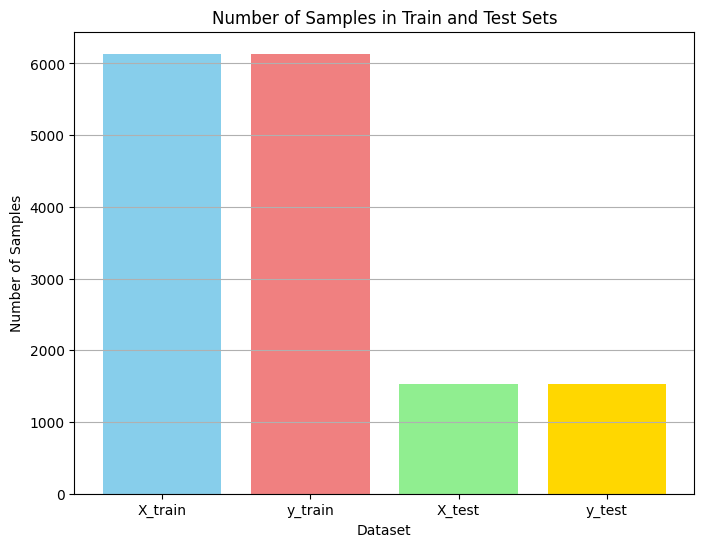

====== FINAL CHECK ======
Type X_train: <class 'numpy.ndarray'>, shape: (6138, 512, 1)
Type y_train: <class 'numpy.ndarray'>, shape: (6138, 5)
Type X_test: <class 'numpy.ndarray'>, shape: (1535, 512, 1)
Type y_test: <class 'numpy.ndarray'>, shape: (1535, 5)


In [18]:
# prepare_data_for_training.py

import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt

# ===== Config paths =====

fusion_with_vector_csv = './dataset/fusion_with_vector_extended.csv'

# ===== Load dataset =====

try:
    df = pd.read_csv(fusion_with_vector_csv)
except Exception as e:
    print(f"Lỗi khi load fusion_with_vector_extended.csv: {e}")
    exit()

print(f"✅ Đã load {len(df)} dòng từ {fusion_with_vector_csv}")

# Chỉ giữ lại dòng có label hợp lệ
df = df[df['Label'].apply(lambda x: isinstance(x, str) and x.strip() != '')]

# ===== Parse FusionVector từ chuỗi sang np.array =====

def parse_fusion_vector(vec_string):
    try:
        return np.fromstring(vec_string, sep=' ')
    except Exception as e:
        print(f"Error parsing fusion vector: {e}")
        return np.zeros(512)  # fallback nếu lỗi

df['FusionVector_array'] = df['FusionVector'].apply(parse_fusion_vector)

# ===== Kiểm tra vector lỗi =====
invalid_rows = df[~df['FusionVector_array'].apply(lambda x: isinstance(x, np.ndarray) and x.shape == (512,))]

print(f"⚠️ Có {len(invalid_rows)} vector không hợp lệ (không có shape 512).")

# In index và độ dài vector
for idx, row in invalid_rows.iterrows():
    vec = row['FusionVector_array']
    print(f"❌ Row {idx}: shape = {vec.shape if isinstance(vec, np.ndarray) else 'Not array'}, Label = {row['Label']}")


print("✅ Đã parse FusionVector thành np.array.")

# ===== Chuẩn bị X, y =====

# X là FusionVector, y là Label
X = np.stack(df['FusionVector_array'].values)
y_labels = df['Label'].values

print(f"✅ X có shape {X.shape}")
print(f"✅ y có shape {y_labels.shape}")

# ===== One-hot encode Label =====

lb = LabelBinarizer()
y = lb.fit_transform(y_labels)

print(f"✅ Đã one-hot encode Label thành shape {y.shape}")

# ===== Reshape X cho CNN/BiLSTM =====

# Reshape (batch_size, 512, 1) cho 1D CNN hoặc BiLSTM input
X = X.reshape(X.shape[0], X.shape[1], 1)

print(f"✅ X sau reshape có shape {X.shape}")

# ===== Split train/test =====

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"✅ Đã chia dữ liệu: Train {X_train.shape[0]} samples, Test {X_test.shape[0]} samples.")

# ===== Visualization: Số lượng mẫu train/test =====

# Data for bar chart
data = {
    'Dataset': ['X_train', 'y_train', 'X_test', 'y_test'],
    'Number of Samples': [X_train.shape[0], y_train.shape[0], X_test.shape[0], y_test.shape[0]]
}

df_vis = pd.DataFrame(data)

# Create the bar chart
plt.figure(figsize=(8, 6))
plt.bar(df_vis['Dataset'], df_vis['Number of Samples'], color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
plt.xlabel('Dataset')
plt.ylabel('Number of Samples')
plt.title('Number of Samples in Train and Test Sets')
plt.grid(axis='y')
plt.show()

# ===== In lại kiểm tra cuối =====

print("====== FINAL CHECK ======")
print(f"Type X_train: {type(X_train)}, shape: {X_train.shape}")
print(f"Type y_train: {type(y_train)}, shape: {y_train.shape}")
print(f"Type X_test: {type(X_test)}, shape: {X_test.shape}")
print(f"Type y_test: {type(y_test)}, shape: {y_test.shape}")


## train and evaluate model

Epoch 1/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.2612 - loss: 2.2535

154/154 ━━━━━━━━━━━━━━━━━━━━ 53s 296ms/step - accuracy: 0.2613 - loss: 2.2516 - val_accuracy: 0.3127 - val_loss: 1.7316
Epoch 2/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.2990 - loss: 1.6967

154/154 ━━━━━━━━━━━━━━━━━━━━ 46s 298ms/step - accuracy: 0.2991 - loss: 1.6964 - val_accuracy: 0.3103 - val_loss: 1.5168
Epoch 3/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.3473 - loss: 1.4550

154/154 ━━━━━━━━━━━━━━━━━━━━ 80s 286ms/step - accuracy: 0.3473 - loss: 1.4551 - val_accuracy: 0.3485 - val_loss: 1.3979
Epoch 4/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 82s 288ms/step - accuracy: 0.3829 - loss: 1.3337 - val_accuracy: 0.3852 - val_loss: 1.5838
Epoch 5/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.4128 - loss: 1.2831

154/154 ━━━━━━━━━━━━━━━━━━━━ 45s 290ms/step - accuracy: 0.4130 - loss: 1.2826 - val_accuracy: 0.6645 - val_loss: 0.9783
Epoch 6/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.6175 - loss: 0.9705

154/154 ━━━━━━━━━━━━━━━━━━━━ 46s 298ms/step - accuracy: 0.6175 - loss: 0.9704 - val_accuracy: 0.6564 - val_loss: 0.8545
Epoch 7/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.7441 - loss: 0.7096

154/154 ━━━━━━━━━━━━━━━━━━━━ 46s 299ms/step - accuracy: 0.7442 - loss: 0.7094 - val_accuracy: 0.8176 - val_loss: 0.6426
Epoch 8/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.7805 - loss: 0.6626

154/154 ━━━━━━━━━━━━━━━━━━━━ 80s 289ms/step - accuracy: 0.7805 - loss: 0.6625 - val_accuracy: 0.8168 - val_loss: 0.6082
Epoch 9/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.8125 - loss: 0.6008

154/154 ━━━━━━━━━━━━━━━━━━━━ 46s 296ms/step - accuracy: 0.8125 - loss: 0.6006 - val_accuracy: 0.8575 - val_loss: 0.5033
Epoch 10/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 46s 297ms/step - accuracy: 0.8329 - loss: 0.5185 - val_accuracy: 0.8371 - val_loss: 0.5521
Epoch 11/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 45s 290ms/step - accuracy: 0.8308 - loss: 0.4995 - val_accuracy: 0.8339 - val_loss: 0.5036
Epoch 12/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 44s 286ms/step - accuracy: 0.8415 - loss: 0.4777 - val_accuracy: 0.8314 - val_loss: 0.6263
Epoch 13/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.8507 - loss: 0.4494

154/154 ━━━━━━━━━━━━━━━━━━━━ 47s 303ms/step - accuracy: 0.8506 - loss: 0.4495 - val_accuracy: 0.8559 - val_loss: 0.4426
Epoch 14/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.8564 - loss: 0.4308

154/154 ━━━━━━━━━━━━━━━━━━━━ 45s 292ms/step - accuracy: 0.8564 - loss: 0.4308 - val_accuracy: 0.8591 - val_loss: 0.3807
Epoch 15/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 46s 297ms/step - accuracy: 0.8708 - loss: 0.3941 - val_accuracy: 0.7923 - val_loss: 0.5505
Epoch 16/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.8649 - loss: 0.3961

154/154 ━━━━━━━━━━━━━━━━━━━━ 44s 286ms/step - accuracy: 0.8649 - loss: 0.3961 - val_accuracy: 0.8852 - val_loss: 0.3525
Epoch 17/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 45s 296ms/step - accuracy: 0.8817 - loss: 0.3634 - val_accuracy: 0.8469 - val_loss: 0.4121
Epoch 18/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.8921 - loss: 0.3721

154/154 ━━━━━━━━━━━━━━━━━━━━ 82s 297ms/step - accuracy: 0.8921 - loss: 0.3720 - val_accuracy: 0.9088 - val_loss: 0.3426
Epoch 19/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 81s 292ms/step - accuracy: 0.9053 - loss: 0.3480 - val_accuracy: 0.8819 - val_loss: 0.3832
Epoch 20/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 45s 291ms/step - accuracy: 0.9020 - loss: 0.3384 - val_accuracy: 0.9088 - val_loss: 0.3669
Epoch 21/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.9134 - loss: 0.3213

154/154 ━━━━━━━━━━━━━━━━━━━━ 45s 292ms/step - accuracy: 0.9133 - loss: 0.3213 - val_accuracy: 0.9324 - val_loss: 0.2979
Epoch 22/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.9264 - loss: 0.2867

154/154 ━━━━━━━━━━━━━━━━━━━━ 83s 301ms/step - accuracy: 0.9264 - loss: 0.2866 - val_accuracy: 0.9316 - val_loss: 0.2847
Epoch 23/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 46s 300ms/step - accuracy: 0.9331 - loss: 0.2669 - val_accuracy: 0.9235 - val_loss: 0.3061
Epoch 24/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 43s 276ms/step - accuracy: 0.9347 - loss: 0.2509 - val_accuracy: 0.9267 - val_loss: 0.2970
Epoch 25/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.9381 - loss: 0.2584

154/154 ━━━━━━━━━━━━━━━━━━━━ 85s 297ms/step - accuracy: 0.9381 - loss: 0.2585 - val_accuracy: 0.9357 - val_loss: 0.2695
Epoch 26/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.9496 - loss: 0.2411

154/154 ━━━━━━━━━━━━━━━━━━━━ 41s 268ms/step - accuracy: 0.9495 - loss: 0.2412 - val_accuracy: 0.9503 - val_loss: 0.2434
Epoch 27/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 46s 299ms/step - accuracy: 0.9474 - loss: 0.2113 - val_accuracy: 0.9259 - val_loss: 0.2971
Epoch 28/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 43s 280ms/step - accuracy: 0.9293 - loss: 0.2865 - val_accuracy: 0.9446 - val_loss: 0.2456
Epoch 29/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.9516 - loss: 0.2157

154/154 ━━━━━━━━━━━━━━━━━━━━ 44s 287ms/step - accuracy: 0.9516 - loss: 0.2157 - val_accuracy: 0.9463 - val_loss: 0.2420
Epoch 30/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.9427 - loss: 0.2361

154/154 ━━━━━━━━━━━━━━━━━━━━ 44s 283ms/step - accuracy: 0.9427 - loss: 0.2362 - val_accuracy: 0.9552 - val_loss: 0.2304
Epoch 31/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 45s 293ms/step - accuracy: 0.9489 - loss: 0.2299 - val_accuracy: 0.9471 - val_loss: 0.2494
Epoch 32/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 41s 267ms/step - accuracy: 0.9517 - loss: 0.2253 - val_accuracy: 0.9365 - val_loss: 0.2655
Epoch 33/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 36s 236ms/step - accuracy: 0.9515 - loss: 0.2180 - val_accuracy: 0.9332 - val_loss: 0.2753
Epoch 34/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 41s 236ms/step - accuracy: 0.9452 - loss: 0.2400 - val_accuracy: 0.9487 - val_loss: 0.2311
Epoch 35/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.9474 - loss: 0.2104

154/154 ━━━━━━━━━━━━━━━━━━━━ 34s 222ms/step - accuracy: 0.9474 - loss: 0.2105 - val_accuracy: 0.9487 - val_loss: 0.2247
Epoch 36/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.9557 - loss: 0.1994

154/154 ━━━━━━━━━━━━━━━━━━━━ 42s 228ms/step - accuracy: 0.9557 - loss: 0.1994 - val_accuracy: 0.9577 - val_loss: 0.2161
Epoch 37/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 33s 214ms/step - accuracy: 0.9508 - loss: 0.2033 - val_accuracy: 0.9544 - val_loss: 0.2201
Epoch 38/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 33s 212ms/step - accuracy: 0.9459 - loss: 0.2272 - val_accuracy: 0.9511 - val_loss: 0.2183
Epoch 39/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.9612 - loss: 0.1873

154/154 ━━━━━━━━━━━━━━━━━━━━ 35s 227ms/step - accuracy: 0.9612 - loss: 0.1873 - val_accuracy: 0.9511 - val_loss: 0.2055
Epoch 40/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 33s 217ms/step - accuracy: 0.9461 - loss: 0.2032 - val_accuracy: 0.9397 - val_loss: 0.2504
Epoch 41/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.9481 - loss: 0.2128

154/154 ━━━━━━━━━━━━━━━━━━━━ 34s 218ms/step - accuracy: 0.9482 - loss: 0.2127 - val_accuracy: 0.9552 - val_loss: 0.2044
Epoch 42/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.9595 - loss: 0.1864

154/154 ━━━━━━━━━━━━━━━━━━━━ 32s 210ms/step - accuracy: 0.9595 - loss: 0.1864 - val_accuracy: 0.9585 - val_loss: 0.1937
Epoch 43/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 32s 208ms/step - accuracy: 0.9575 - loss: 0.1837 - val_accuracy: 0.9235 - val_loss: 0.2469
Epoch 44/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 33s 211ms/step - accuracy: 0.9525 - loss: 0.1982 - val_accuracy: 0.9243 - val_loss: 0.2953
Epoch 45/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 33s 217ms/step - accuracy: 0.9431 - loss: 0.2221 - val_accuracy: 0.9186 - val_loss: 0.3033
Epoch 46/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 32s 207ms/step - accuracy: 0.9478 - loss: 0.2095 - val_accuracy: 0.9503 - val_loss: 0.2107
Epoch 47/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 32s 205ms/step - accuracy: 0.9570 - loss: 0.1738 - val_accuracy: 0.9495 - val_loss: 0.2263

=== Evaluating Model ===
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step
✅ Accuracy: 0.9648
✅ Precision: 0.9650
✅ Recall: 0.9648
✅ F1 Score: 0.9648
⏱️ Detection Time (total): 5.0831 seconds
⏱️ Detection Time (per sample): 0.003

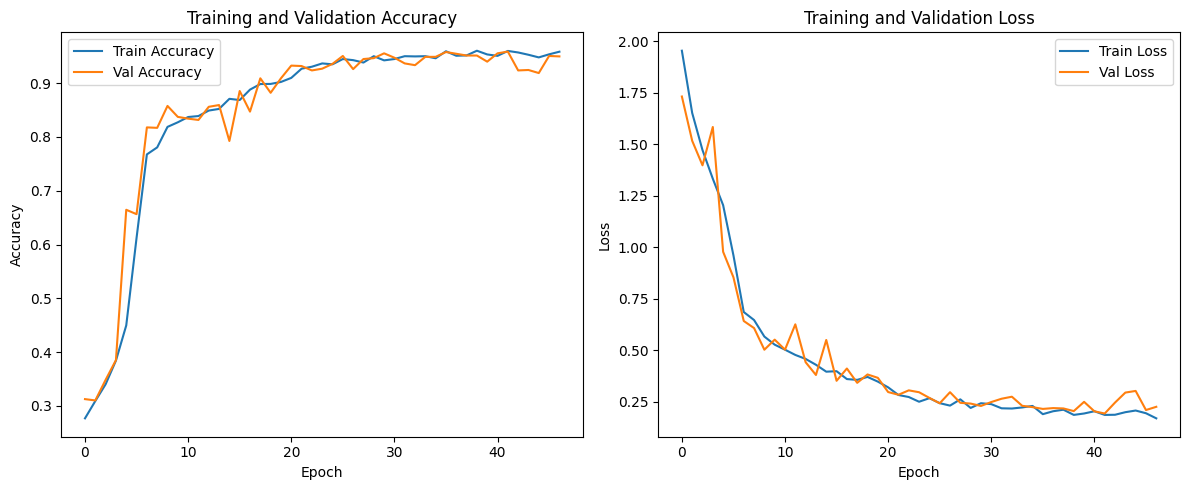

In [12]:
# ====== train_cnn_bilstm_attention.py ======

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Bidirectional, LSTM
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
from sklearn.utils.multiclass import unique_labels
from tensorflow.keras.callbacks import ModelCheckpoint
import time

# ===== Config =====
INPUT_SHAPE = (512, 1)   # Vì fusion vector có 512 chiều
NUM_CLASSES = 5
BATCH_SIZE = 32
EPOCHS = 50
PATIENCE = 5
LEARNING_RATE = 1e-3

# ===== Build Model =====
def build_model(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES):
    input_layer = Input(shape=input_shape)

    x = Conv1D(filters=32, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001))(input_layer)
    x = MaxPooling1D(pool_size=2)(x)

    x = Conv1D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = MaxPooling1D(pool_size=2)(x)

    x = Bidirectional(LSTM(32, return_sequences=True, kernel_regularizer=l2(0.001)))(x)

    x = MultiHeadAttention(num_heads=4, key_dim=128)(x, x)
    
    x = LayerNormalization()(x)
    x = Dropout(0.3)(x)

    x = Flatten()(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)

    output_layer = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    optimizer = Adam(learning_rate=LEARNING_RATE)

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# ===== Train Model =====
def train_model(model, X_train, y_train):
    checkpoint_cb = ModelCheckpoint("./cnn_bilstm_attention.h5", 
                                monitor='val_loss', 
                                save_best_only=True, 
                                save_weights_only=False)
    
    early_stop = EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)

    history = model.fit(X_train, y_train,
                        validation_split=0.2,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        callbacks=[early_stop, checkpoint_cb],
                        verbose=1)
    return history

# ===== Evaluate Model =====
def evaluate_model(model, X_test, y_test, target_names):
    print("\n=== Evaluating Model ===")

    start_time = time.time()
    y_pred = model.predict(X_test)
    end_time = time.time()

    detection_time = end_time - start_time
    avg_time_per_sample = detection_time / len(X_test)

    y_pred_labels = np.argmax(y_pred, axis=1)

    if y_test.shape[1] > 1:
        y_test_labels = np.argmax(y_test, axis=1)
    else:
        y_test_labels = y_test

    precision = precision_score(y_test_labels, y_pred_labels, average='weighted', zero_division=0)
    recall = recall_score(y_test_labels, y_pred_labels, average='weighted', zero_division=0)
    f1 = f1_score(y_test_labels, y_pred_labels, average='weighted', zero_division=0)
    acc = accuracy_score(y_test_labels, y_pred_labels)

    print(f"✅ Accuracy: {acc:.4f}")
    print(f"✅ Precision: {precision:.4f}")
    print(f"✅ Recall: {recall:.4f}")
    print(f"✅ F1 Score: {f1:.4f}")
    print(f"⏱️ Detection Time (total): {detection_time:.4f} seconds")
    print(f"⏱️ Detection Time (per sample): {avg_time_per_sample:.6f} seconds")

    print("\n=== Classification Report ===")
    labels_in_test = sorted(list(unique_labels(y_test_labels, y_pred_labels)))
    target_names_subset = [target_names[i] for i in labels_in_test]
    print(classification_report(y_test_labels, y_pred_labels, target_names=target_names_subset, digits=4, zero_division=0))

# ===== Plot Training Curves =====
def plot_training_curves(history):
    print("\n=== Plotting Training Curves ===")
    plt.figure(figsize=(12,5))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# ===== Main Process =====
if __name__ == "__main__":
    # Load data
    df = pd.read_csv('./dataset/fusion_with_vector_extended.csv')

    df = df[df['Label'].apply(lambda x: isinstance(x, str) and x.strip() != '')]

    def parse_fusion_vector(vec_string):
        return np.fromstring(vec_string, sep=' ')

    df['FusionVector_array'] = df['FusionVector'].apply(parse_fusion_vector)

    X = np.stack(df['FusionVector_array'].values)
    y_labels = df['Label'].values

    lb = LabelBinarizer()
    y = lb.fit_transform(y_labels)

    X = X.reshape(X.shape[0], X.shape[1], 1)

    # --- Chia train/test có stratify để không mất lớp nhỏ ---
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.2, 
                                                        random_state=42, 
                                                        stratify=y)

    target_names = lb.classes_.tolist()

    # Build, Train, Evaluate
    model = build_model()
    history = train_model(model, X_train, y_train)
    
    evaluate_model(model, X_test, y_test, target_names)
    plot_training_curves(history)

# Test

## Random sample

In [13]:
import pandas as pd

# Đọc toàn bộ dữ liệu
df = pd.read_csv('./dataset/fusion_with_vector_extended.csv')

# Lấy ngẫu nhiên 10 dòng
sample_df = df.sample(n=10, random_state=42)  # random_state để có thể tái lập kết quả

# Ghi ra file CSV mới
sample_df.to_csv('./dataset/test_sample.csv', index=False)

print("✅ Đã tạo file test_sample.csv với 10 dòng ngẫu nhiên.")

✅ Đã tạo file test_sample.csv với 10 dòng ngẫu nhiên.


## Test predict

In [14]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelBinarizer

# ===== Load model =====
model = load_model('./cnn_bilstm_attention.h5')
print("✅ Model loaded.")

# ===== Load và xử lý dữ liệu =====
df = pd.read_csv('./dataset/test_sample.csv')

# Bỏ dòng không hợp lệ
df = df[df['Label'].apply(lambda x: isinstance(x, str) and x.strip() != '')]

def parse_fusion_vector(vec_string):
    return np.fromstring(vec_string, sep=' ')

df['FusionVector_array'] = df['FusionVector'].apply(parse_fusion_vector)

X = np.stack(df['FusionVector_array'].values)
y_labels = df['Label'].values

lb = LabelBinarizer()
y = lb.fit_transform(y_labels)

X = X.reshape(X.shape[0], X.shape[1], 1)

# ===== Dự đoán lại =====
y_pred = model.predict(X)
y_pred_labels = np.argmax(y_pred, axis=1)
label_names = lb.classes_

print("=== Sample Predictions ===")
for i in range(5):
    print(f"▶ True: {y_labels[i]} → Predicted: {label_names[y_pred_labels[i]]}")


✅ Model loaded.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step
=== Sample Predictions ===
▶ True: TaskExecution → Predicted: TaskExecution
▶ True: Downloader → Predicted: Downloader
▶ True: Payload → Predicted: Payload
▶ True: Payload → Predicted: Payload
▶ True: Injector → Predicted: Injector


In [3]:
import pandas as pd

# Đọc file CSV
df = pd.read_csv('./dataset/data_labeled_extended.csv')

# Đếm số lượng mẫu cho cột Label
print("Số lượng mẫu cho mỗi label:")
print("=" * 40)
label_counts = df['Label'].value_counts()
print(label_counts)

# Hiển thị tỷ lệ phần trăm
print("\nTỷ lệ phần trăm:")
print("=" * 40)
label_percentages = (label_counts / len(df)) * 100
print(label_percentages.round(2))

# Hiển thị dưới dạng DataFrame đẹp hơn
print("\nBảng thống kê chi tiết:")
print("=" * 40)
result = pd.DataFrame({
    'Label': label_counts.index,
    'Count': label_counts.values,
    'Percentage': (label_counts / len(df) * 100).round(2)
})
print(result)

# Tổng số mẫu
print(f"\nTổng số mẫu: {len(df)}")
print(f"Số loại label: {len(label_counts)}")

# Kiểm tra xem có đúng 5 loại không
expected_labels = {'Bypass', 'Downloader', 'Injector', 'Payload', 'TaskExecution'}
actual_labels = set(df['Label'].unique())
print(f"\nCác label có trong dataset: {actual_labels}")
print(f"Đúng 5 label mong đợi: {actual_labels == expected_labels}")

Số lượng mẫu cho mỗi label:
Label
Payload          2424
TaskExecution    1581
Downloader       1511
Injector         1178
Bypass            979
Name: count, dtype: int64

Tỷ lệ phần trăm:
Label
Payload          31.58
TaskExecution    20.60
Downloader       19.68
Injector         15.35
Bypass           12.75
Name: count, dtype: float64

Bảng thống kê chi tiết:
                       Label  Count  Percentage
Label                                          
Payload              Payload   2424       31.58
TaskExecution  TaskExecution   1581       20.60
Downloader        Downloader   1511       19.68
Injector            Injector   1178       15.35
Bypass                Bypass    979       12.75

Tổng số mẫu: 7676
Số loại label: 5

Các label có trong dataset: {'Payload', 'TaskExecution', 'Bypass', 'Downloader', nan, 'Injector'}
Đúng 5 label mong đợi: False
